In [122]:
import os
import sys
from pathlib import Path

import Dataloader_mmd_ce

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [123]:
window_size = 1024
overlap_size = 0
vel_cut_off_value = 0
#features_of_interest = ['S:x_bottom', 'S:y_bottom', 'S:z_bottom', 'S:x_nut', 'S:y_nut', 'S:z_nut', 'S:x_top', 'S:y_top', 'S:z_top', 'S:Nominal_rotational_speed[rad/s]', 'S:Actual_rotational_speed[µm/s]', 'S:Actual_position_of_the_position_encoder(dy/dt)[µm/s]', 'S:Actual_position_of_the_motor_encoder(dy/dt)[µm/s]']
features_of_interest = ['C:x_bottom', 'C:y_bottom', 'C:z_bottom']

list_of_source_BSD_states = ["2", "3", "11", "12", "20", "21"]
list_of_target_BSD_states = ["5", "6", "14", "15", "23", "24"]
data_path = Path(os.getcwd()).parents[1]
data_path = os.path.join(data_path, "data")
dataloader_split_ce = 0.2
dataloader_split_mmd = 0.6
dataloader_split_val = 0.2
batch_size = 32

source_loader = Dataloader_mmd_ce.create_dataloader(data_path, list_of_source_BSD_states, window_size, overlap_size, features_of_interest, dataloader_split_ce, dataloader_split_mmd, dataloader_split_val, batch_size)
target_loader = Dataloader_mmd_ce.create_dataloader(data_path, list_of_target_BSD_states, window_size, overlap_size, features_of_interest, dataloader_split_ce, dataloader_split_mmd, dataloader_split_val, batch_size)




1/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/046_2020_04_23.csv
Shape of collected datafram: X_shape: (73, 3, 1024), Y_shape: (73,)
2/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/037_2020_04_23.csv
Shape of collected datafram: X_shape: (146, 3, 1024), Y_shape: (146,)
3/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/041_2020_04_23.csv
Shape of collected datafram: X_shape: (219, 3, 1024), Y_shape: (219,)
4/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/038_2020_04_23.csv
Shape of collected datafram: X_shape: (292, 3, 1024), Y_shape: (292,)
5/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/039_2020_04_23.csv
Shape of collected datafram: X_shape: (365, 3, 1024), Y_shape: (365,)
6/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/040_2020_04_23.csv
Shape of collected datafram: X_shape: (438, 3, 1024), Y_shape: (438,)
7/60 folders downloaded
downloaded folder:

52/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/249_2020_05_08.csv
Shape of collected datafram: X_shape: (3796, 3, 1024), Y_shape: (3796,)
53/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/246_2020_05_08.csv
Shape of collected datafram: X_shape: (3869, 3, 1024), Y_shape: (3869,)
54/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/247_2020_05_08.csv
Shape of collected datafram: X_shape: (3942, 3, 1024), Y_shape: (3942,)
55/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/248_2020_05_08.csv
Shape of collected datafram: X_shape: (4015, 3, 1024), Y_shape: (4015,)
56/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/240_2020_05_08.csv
Shape of collected datafram: X_shape: (4088, 3, 1024), Y_shape: (4088,)
57/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/242_2020_05_08.csv
Shape of collected datafram: X_shape: (4161, 3, 1024), Y_shape: (4161,)
58/60 folders download

43/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/289_2020_05_11.csv
Shape of collected datafram: X_shape: (3139, 3, 1024), Y_shape: (3139,)
44/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/294_2020_05_11.csv
Shape of collected datafram: X_shape: (3212, 3, 1024), Y_shape: (3212,)
45/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/286_2020_05_11.csv
Shape of collected datafram: X_shape: (3285, 3, 1024), Y_shape: (3285,)
46/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/293_2020_05_11.csv
Shape of collected datafram: X_shape: (3358, 3, 1024), Y_shape: (3358,)
47/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/292_2020_05_11.csv
Shape of collected datafram: X_shape: (3431, 3, 1024), Y_shape: (3431,)
48/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/287_2020_05_11.csv
Shape of collected datafram: X_shape: (3504, 3, 1024), Y_shape: (3504,)
49/60 folders download

In [163]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


In [164]:
class CNN(nn.Module):
    def __init__(self, input_size, input_fc_size, hidden_fc_size_1):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=100, stride=1)#input: ((1024+2*0-(100-1)-1)/1)+1 = 925
        self.pool1 = nn.MaxPool1d(4, stride=3) #((925+2*0-1*(4-1)-1)/3)+1 = 308
        self.conv2 = nn.Conv1d(64,32,kernel_size=10, stride = 1, padding=1)#input: ((308+2*1-(10-1)-1)/1)+1 = 301
        self.batch1 =nn.BatchNorm1d(32) #301
        self.pool2 = nn.MaxPool1d(4, stride=3) #((301+2*0-1*(4-1)-1)/3)+1 = 100
        self.conv3 = nn.Conv1d(32,32,kernel_size=5, stride = 1, padding=1) #((100+2*1-(5-1)-1)/1)+1 = 98
        self.batch2 =nn.BatchNorm1d(32) #98
        #self.pool3 = nn.MaxPool1d(5, stride=3) #((98+2*0-1*(5-1)-1)/3)+1 = 32
        self.fc1 = nn.Linear(input_fc_size, hidden_fc_size_1)
    
    def forward(self, x):
        x_conv_1 = self.conv1(x) #conv1
        x = F.relu(x_conv_1) #relu
        x = self.pool1(x) #pool1
        x_conv_2 = self.conv2(x) #conv2
        x = self.batch1(x_conv_2) #batch1
        x = F.relu(x) #relu
        x = self.pool2(x) #pool2
        x_conv_3 = self.conv3(x) #conv3
        x = self.batch2(x_conv_3) #batch2
        x = F.relu(x) #relu
        #x = self.pool3(x) #pool3
        x_flatten = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2])) #flatten
        x_normalize = torch.nn.functional.normalize(x_flatten)
        x_fc1 = self.fc1(x_normalize) #fc1
        
        return x_conv_1, x_conv_2, x_conv_3, x_flatten, x_fc1

In [165]:
class Classifier(nn.Module):
    def __init__(self, hidden_fc_size_1, hidden_fc_size_2, output_size):
        super(Classifier, self).__init__()
        self.fc2 = nn.Linear(hidden_fc_size_1, hidden_fc_size_2)
        self.fc3 = nn.Linear(hidden_fc_size_2, output_size)

    def forward(self, x):
        x_fc2 = self.fc2(x) #fc2
        x_fc3 = self.fc3(x_fc2) #fc3
        
        return x_fc2, x_fc3



In [166]:
input_size = 3
input_fc_size = 32*98#32
hidden_fc_size_1 = 50
hidden_fc_size_2 = 3
output_size = 2

model_cnn = CNN(input_size, input_fc_size, hidden_fc_size_1)

model_fc = Classifier(hidden_fc_size_1, hidden_fc_size_2, output_size)

print(model_cnn)

print(model_fc)



CNN(
  (conv1): Conv1d(3, 64, kernel_size=(100,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 32, kernel_size=(10,), stride=(1,), padding=(1,))
  (batch1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (batch2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=50, bias=True)
)
Classifier(
  (fc2): Linear(in_features=50, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=2, bias=True)
)


In [167]:
#from mmd_loss import MMD_loss
class MMD_loss(nn.Module):
    def __init__(self, fix_sigma = None, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = fix_sigma
        return
    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma = None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        bandwidth_list = self.fix_sigma
        kernel_val = [torch.exp(-L2_distance / sigma) for sigma in self.fix_sigma]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.gaussian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [168]:

def forward(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag_phase, GAMMA):
    
        #Feature extraction
        x_conv_1, x_conv_2, x_conv_3, x_flatten, x_fc1 = model_cnn(data.float())
        x_fc2, x_fc3 = model_fc(x_fc1)
        
        batch_size = len(labels_source)   

        #CE Loss
        source_ce_loss = criterion(x_fc3[:batch_size, :], labels_source)
        target_ce_loss = criterion(x_fc3[batch_size:, :], labels_target)
        
        #MMD Loss
        mmd_loss_1_fc = MMD_loss_calculator.forward(x_flatten[:batch_size, :], x_flatten[batch_size:, :])
        mmd_loss_2_fc = MMD_loss_calculator.forward(x_fc1[:batch_size, :], x_fc1[batch_size:, :])
        mmd_loss_3_fc = MMD_loss_calculator.forward(x_fc2[:batch_size, :], x_fc2[batch_size:, :])
        
        mmd_loss_1_cnn = 0
        mmd_loss_2_cnn = 0
        mmd_loss_3_cnn = 0
        """
        for channel1 in range(x_conv_1.size()[1]):
            mmd_loss_1_cnn += MMD_loss_calculator.forward(x_conv_1[:batch_size, channel1, :], x_conv_1[batch_size:,channel1, :])
        for channel2 in range(x_conv_2.size()[1]):
            mmd_loss_2_cnn += MMD_loss_calculator.forward(x_conv_2[:batch_size, channel2, :], x_conv_2[batch_size:,channel2, :])
        for channel3 in range(x_conv_3.size()[1]):
            mmd_loss_3_cnn += MMD_loss_calculator.forward(x_conv_3[:batch_size, channel3, :], x_conv_3[batch_size:,channel3, :])
        """

        
        mmd_loss = mmd_loss_1_fc + mmd_loss_2_fc + mmd_loss_3_fc# + mmd_loss_1_cnn + mmd_loss_2_cnn + mmd_loss_3_cnn

        #collect information about labels, predictions to calculate accuracy
        n_correct_source = 0
        n_correct_target = 0
        n_samples_source = 0
        n_samples_target = 0

        # list of classified latent space features in FC1
        class_0_source_fc2 = x_fc2[:batch_size, :][labels_source==0]
        class_1_source_fc2 = x_fc2[:batch_size, :][labels_source==1]
        class_0_target_fc2 = x_fc2[batch_size:, :][labels_target==0]
        class_1_target_fc2 = x_fc2[batch_size:, :][labels_target==1]
        
        argmax_source_pred = torch.argmax(x_fc3[:batch_size, :], dim=1)
        result_source_pred = argmax_source_pred == labels_source
        correct_source_pred = result_source_pred[result_source_pred == True]
        acc_total_source = 100 * len(correct_source_pred)/len(labels_source)
        
        argmax_target_pred = torch.argmax(x_fc3[batch_size:, :], dim=1)
        result_target_pred = argmax_target_pred == labels_target
        correct_target_pred = result_target_pred[result_target_pred == True]
        acc_total_target = 100 * len(correct_target_pred)/len(labels_target)
        
      
        if MMD_loss_flag_phase == True:
            loss = source_ce_loss + mmd_loss
        else:
            loss = source_ce_loss + mmd_loss

        
        return loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_fc2, class_1_source_fc2, class_0_target_fc2, class_1_target_fc2
    



Tensor contains nan values: False, Size of tensor:torch.Size([428, 3]) 
Tensor contains nan values: False, Size of tensor:torch.Size([448, 3]) 
Tensor contains nan values: False, Size of tensor:torch.Size([454, 3]) 
Tensor contains nan values: False, Size of tensor:torch.Size([422, 3]) 


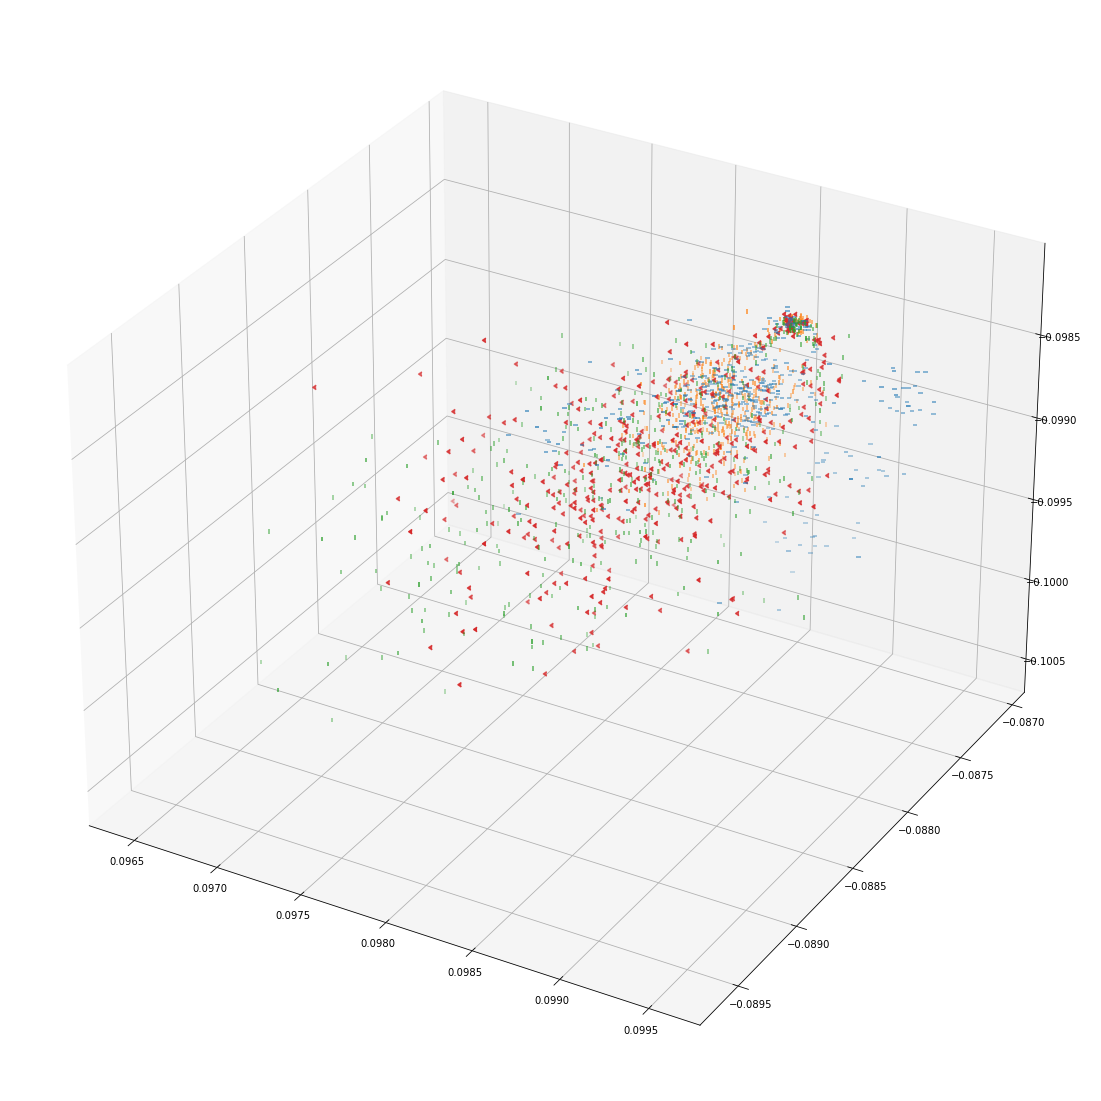

Epoch 1/30 successfull
Epoch 2/30 successfull


In [ ]:
writer_graph = SummaryWriter('runs/Dataloader2/graph')
writer_source_val = SummaryWriter('runs/Dataloader2/source_val')
writer_source_mmd = SummaryWriter('runs/Dataloader2/source_mmd')
writer_source_ce = SummaryWriter('runs/Dataloader2/source_ce')
writer_target_val = SummaryWriter('runs/Dataloader2/target_val')
writer_target_mmd = SummaryWriter('runs/Dataloader2/target_mmd')
writer_target_ce = SummaryWriter('runs/Dataloader2/target_ce')

writer_source = {}
writer_source["val"] = writer_source_val
writer_source["mmd"] = writer_source_mmd
writer_source["ce"] = writer_source_ce

writer_target = {}
writer_target["val"] = writer_target_val
writer_target["mmd"] = writer_target_mmd
writer_target["ce"] = writer_target_ce


#define training params
num_epochs = 30
GAMMA = 2
SIGMA = torch.tensor([1,2,4,8,16],dtype=torch.float64)

#define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
MMD_loss_calculator = MMD_loss(fix_sigma = SIGMA)
#mmd_loss_flag
MMD_loss_flag_phase = {}
MMD_loss_flag_phase["val"] = True
MMD_loss_flag_phase["mmd"] = True
MMD_loss_flag_phase["ce"] = False

optimizer1 = torch.optim.Adam([
{'params': model_cnn.parameters()},
{'params': model_fc.parameters(), 'lr': 1e-4}
], lr=1e-2, betas=(0.9, 0.999))

optimizer2 = torch.optim.Adam(model_fc.parameters(), lr=1e-2, betas=(0.9, 0.999))


#training iterations
phases = ['val', 'mmd', 'ce']


#init train data for each batch
loss_collected = 0
source_ce_loss_collected = 0
target_ce_loss_collected = 0
mmd_loss_collected = 0
acc_total_source_collected = 0
acc_total_target_collected = 0

#plot lists
mmd_loss_list = {}
mmd_loss_list['val']=[]
mmd_loss_list['mmd']=[]
mmd_loss_list['ce'] = []

ce_loss_list_source = {}
ce_loss_list_source['val']=[]
ce_loss_list_source['mmd']=[]
ce_loss_list_source['ce'] = []

ce_loss_list_target = {}
ce_loss_list_target['val']=[]
ce_loss_list_target['mmd']=[]
ce_loss_list_target['ce'] = []

accuracy_list_source = {}
accuracy_list_source['val']=[]
accuracy_list_source['mmd']=[]
accuracy_list_source['ce'] = []

accuracy_list_target = {}
accuracy_list_target['val']=[]
accuracy_list_target['mmd']=[]
accuracy_list_target['ce'] = []

# Train and Validate the model
for epoch in range(num_epochs):
    #plot mmd
    class_0_source_fc2_collect = torch.empty((0,3))
    class_1_source_fc2_collect = torch.empty((0,3))
    class_0_target_fc2_collect = torch.empty((0,3))
    class_1_target_fc2_collect = torch.empty((0,3))

    
    for phase in phases:
        iter_loader_source = iter(source_loader[phase])
        iter_loader_target = iter(target_loader[phase])
        for i in range(len(iter_loader_source)):
            
            ########Forward pass########
            data_source, labels_source = iter_loader_source.next() #batch_size number of windows and labels from source domain
            data_target, labels_target = iter_loader_target.next() #batch_size number of windows from target domain
            data = torch.cat((data_source, data_target), dim=0) #concat the windows to 2*batch_size number of windows
            
            
            if phase == "val":
                
                #no training
                model_cnn.train(False)
                model_fc.train(False)
                
                
                with torch.no_grad():
                    _, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_fc2, class_1_source_fc2, class_0_target_fc2, class_1_target_fc2 = forward(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag_phase, GAMMA)
                    
                    # collect latent features for plot 
                    class_0_source_fc2_collect = torch.cat((class_0_source_fc2_collect, class_0_source_fc2), 0)
                    class_1_source_fc2_collect = torch.cat((class_1_source_fc2_collect, class_1_source_fc2), 0)
                    class_0_target_fc2_collect = torch.cat((class_0_target_fc2_collect, class_0_target_fc2), 0)
                    class_1_target_fc2_collect = torch.cat((class_1_target_fc2_collect, class_1_target_fc2), 0)

            elif phase == "mmd":
                
                #training
                model_cnn.train(True)
                model_fc.train(True)
                
                ########Forward pass########
                loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, _, _, _, _ = forward(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag_phase, GAMMA)
                
                mmd_loss = mmd_loss.detach()
                source_ce_loss = source_ce_loss.detach()
                target_ce_loss = target_ce_loss.detach()
                ########Backward pass########
                optimizer1.zero_grad()
                loss.backward()
                optimizer1.step()
                
            elif phase == "ce":
                
                #training
                model_cnn.train(True)
                model_fc.train(True)
                
                ########Forward pass########
                loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, _, _, _, _ = forward(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag_phase, GAMMA)
                
                mmd_loss = mmd_loss.detach()
                source_ce_loss = source_ce_loss.detach()
                target_ce_loss = target_ce_loss.detach()
                ########Backward pass########
                optimizer2.zero_grad()
                loss.backward()
                optimizer2.step()
                
            """
            for name_fc, param_fc in model_fc.named_parameters():
                print(f"name: {name_fc}, params: {param_fc}")
            for name_cnn, param_cnn in model_cnn.named_parameters():
                print(f"name: {name_cnn}, params: {param_cnn}")
            """
            
            # collect train data for each train phase
            mmd_loss_collected += mmd_loss
            source_ce_loss_collected += source_ce_loss
            target_ce_loss_collected += target_ce_loss
            acc_total_source_collected += acc_total_source
            acc_total_target_collected += acc_total_target
            
            
                
        #plot
        if phase == "val" and (epoch ==0 or epoch ==5 or epoch == 10 or epoch ==20):

            fig = plt.figure()
            plt.gcf().set_size_inches((20, 20)) 
            ax = fig.add_subplot(projection='3d')

            m = [1,2,3,4]
            data_plot = [class_0_source_fc2_collect, class_1_source_fc2_collect, class_0_target_fc2_collect, class_1_target_fc2_collect]
            print(f"Tensor contains nan values: {torch.isnan(class_0_source_fc2_collect).any()}, Size of tensor:{class_0_source_fc2_collect.size()} ")
            print(f"Tensor contains nan values: {torch.isnan(class_1_source_fc2_collect).any()}, Size of tensor:{class_1_source_fc2_collect.size()} ")
            print(f"Tensor contains nan values: {torch.isnan(class_0_target_fc2_collect).any()}, Size of tensor:{class_0_target_fc2_collect.size()} ")
            print(f"Tensor contains nan values: {torch.isnan(class_1_target_fc2_collect).any()}, Size of tensor:{class_1_target_fc2_collect.size()} ")
            
            
            for i in range(4):
                ax.scatter(data_plot[i][:,0], data_plot[i][:,1], data_plot[i][:,2], marker=m[i])
                
            
            plt.show()
            fig.savefig(f"no_mmd_epoch{epoch}")            

        
        # Normalize collected train data for each train phase
        running_mmd_loss = mmd_loss_collected / len(source_loader[phase])
        
        running_acc_source = acc_total_source_collected / len(source_loader[phase])
        running_acc_target = acc_total_target_collected / len(target_loader[phase])
        
        running_source_ce_loss = source_ce_loss_collected / len(source_loader[phase])
        running_target_ce_loss = target_ce_loss_collected / len(target_loader[phase])
        
        
        #Add train data to plot list
        accuracy_list_source[phase].append(running_acc_source)
        accuracy_list_target[phase].append(running_acc_target)
        
        ce_loss_list_source[phase].append(running_source_ce_loss)
        ce_loss_list_target[phase].append(running_target_ce_loss)
        
        mmd_loss_list[phase].append(running_mmd_loss)


        #Add train data to tensorflow list
        writer_source[phase].add_scalar(f'accuracy', running_acc_source, epoch)
        writer_target[phase].add_scalar(f'accuracy', running_acc_target, epoch)
        
        writer_source[phase].add_scalar(f'ce_loss', running_source_ce_loss, epoch)
        writer_target[phase].add_scalar(f'ce_loss', running_target_ce_loss, epoch)
        
        writer_source[phase].add_scalar(f'mmd_loss', running_mmd_loss, epoch)
        

        #reset train data for each batch
        loss_collected = 0
        source_ce_loss_collected = 0
        target_ce_loss_collected = 0
        mmd_loss_collected = 0
        acc_total_source_collected = 0
        acc_total_target_collected = 0
            

    print(f"Epoch {epoch+1}/{num_epochs} successfull")




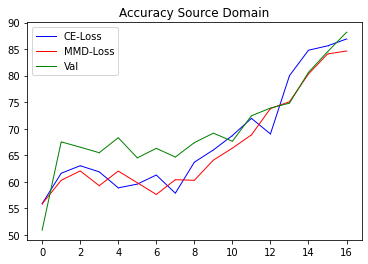

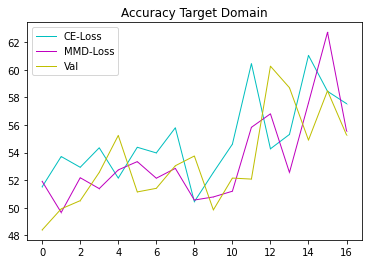

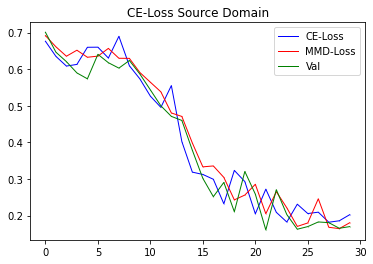

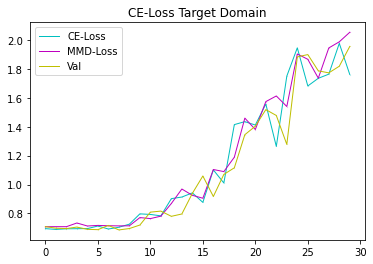

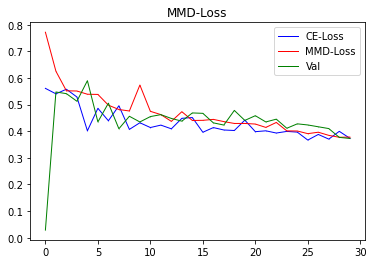

In [162]:
fig1 = plt.figure()
plt.title('Accuracy Source Domain')
plt.plot(accuracy_list_source['ce'][:17], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['mmd'][:17], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['val'][:17], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig1.savefig('Accuracy Source Domain')

fig2 = plt.figure()
plt.title('Accuracy Target Domain')
plt.plot(accuracy_list_target['ce'][:17], 'co-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['mmd'][:17], 'mo-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['val'][:17], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig2.savefig('Accuracy Target Domain')

fig3 = plt.figure()
plt.title('CE-Loss Source Domain')
plt.plot(ce_loss_list_source['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig3.savefig('CE_Loss Source Domain')

fig4 = plt.figure()
plt.title('CE-Loss Target Domain')
plt.plot(ce_loss_list_target['ce'], 'co-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['mmd'], 'mo-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig4.savefig('CE_Loss Target Domain')

fig5 = plt.figure()
plt.title('MMD-Loss')
plt.plot(mmd_loss_list['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig5.savefig('MMD_Loss')

In [87]:

        
with torch.no_grad():
    classes = ['BSD_11', 'BSD_21', 'BSD_31', 'BSD_P1']
    
    #collect information about labels, predictions
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(4)]
    n_class_samples = [0 for i in range(4)]
    n_class_samples_out = [0 for i in range(4)]
    #iterate through batches in target_loader
    for window, labels in target_loader["test"]:
        #make predictions for each batch
        flatten_outputs = model(window.float())
        outputs_hidden_layer = classifier_layer_1(flatten_outputs)
        outputs = classifier_layer_2(outputs_hidden_layer)
        #for each element in batch check if prediction is correct and collect total and correct predictions and labels
        for i in range(len(labels)):
            label = labels[i]
            output = torch.argmax(outputs[i])
            if label == output:
                n_correct+=1
                n_class_correct[label]+=1
                
            n_samples+=1
            n_class_samples[label]+=1
            n_class_samples_out[output]+=1

    
    #calculate total accuracy
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    
    #calculate class accuracy
    for i in range(4):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

KeyError: 'test'

In [ ]:
print(n_class_samples)
print(n_class_samples_out)
print(n_class_correct)

In [ ]:
print(f"{accuracy_list['val'][-1]*100} %")

In [72]:
test = torch.tensor([1.,2.,nan.])

SyntaxError: invalid syntax (1628150502.py, line 1)